In [1]:
#pip install tld


  Using cached tld-0.13.1-py2.py3-none-any.whl.metadata (10 kB)
Using cached tld-0.13.1-py2.py3-none-any.whl (274 kB)


In [2]:
# Kütüphaneleri ve fonksiyonları çağırma, veri işlemleri ve modeller için hazırlık
import re                       # Metin üzerinde desen arama ve düzenleme işlemleri
import numpy as np               # Sayısal hesaplamalar ve matris işlemleri
import pandas as pd              # Veri setlerini okuma, inceleme ve işleme
import seaborn as sns            # Veri görselleştirme
import matplotlib.pyplot as plt  # Grafik çizimi
from colorama import Fore        # Konsol çıktılarında renkli yazı
from urllib.parse import urlparse  # URL'leri parçalara ayırmak için
from sklearn.model_selection import train_test_split  # Eğitim ve test kümelerini ayırmak için
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score  # Model performans ölçümü
from sklearn.tree import DecisionTreeClassifier       # Karar ağacı sınıflandırması
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier  # Topluluk yöntemleri
from sklearn.neighbors import KNeighborsClassifier    # KNN sınıflandırması
from sklearn.linear_model import SGDClassifier       # Stokastik gradyan inişi sınıflandırması
from sklearn.naive_bayes import GaussianNB           # Naive Bayes sınıflandırması
from tld import get_tld, is_tld                      # URL’den TLD almak ve doğrulamak için

In [3]:
# CSV dosyasını okuyarak veriyi bir tabloya yükleme ve ilk 5 satırı görüntüleme
data = pd.read_csv(r"C:\Users\sulen\OneDrive\Masaüstü\Python ile Veri Analizi Atölyesi\malicious_phish.csv")
data.head()  # Tablo yapısını ve örnek verileri inceleme

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


Tablodaki ilk beş satır, web adreslerinin farklı türlerini ve bunlara karşılık gelen kategorilerini gösteriyor. Bazıları zararlı (phishing, defacement), bazıları ise güvenli (benign) olarak işaretlenmiş. Bu örnek, veri setinin hem zararlı hem de güvenli bağlantıları içerdiğini ve sınıflandırma için kullanılabileceğini gösteriyor.

In [4]:
# DataFrame'in yapısı hakkında bilgi alma
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


Veri setinde 651.191 satır ve 2 sütun bulunuyor: "url" ve "type". Her iki sütunda da boş değer yok, yani veri eksiksiz. Her iki sütun da metin (object) formatında. Bellek kullanımı yaklaşık 10 MB, bu da veri setinin büyük ama yönetilebilir olduğunu gösteriyor.

In [5]:
# Boş değerlerin olup olmadığını kontrol etme
data.isnull().sum()

url     0
type    0
dtype: int64

In [6]:
# Her kategori için kayıt sayısını hesaplama
count = data.type.value_counts()
count

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

Veri setinde en fazla örneğe sahip kategori benign yani zararsız URL’lerdir (428.103 kayıt). Bunu defacement (site değişikliği) ve phishing (oltalama) takip ediyor ve en az örnek malware yani zararlı yazılım URL’lerinde bulunuyor (32.520 kayıt). Bu dağılım, sınıflar arasında belirgin bir dengesizlik olduğunu ve bazı kategorilerde veri sayısının az olduğunu gösteriyor. Bu, model eğitimi sırasında dikkate alınması gereken bir durumdur.

Text(0, 0.5, 'Count')

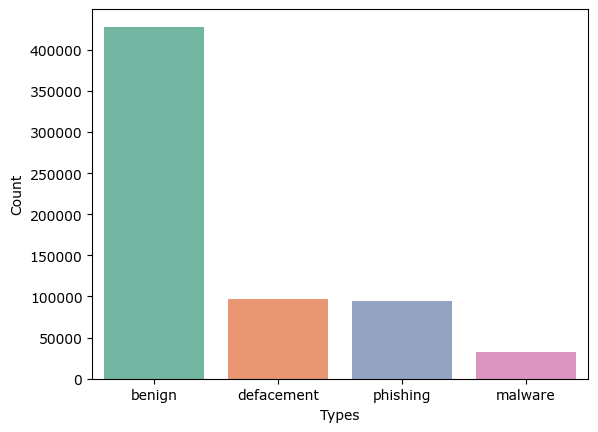

In [7]:
# URL türlerinin sayısını görselleştirmek için çubuk grafik çizimi
sns.barplot(x=count.index, y=count, hue=count.index, dodge=False, palette="Set2", legend=False)
plt.xlabel("Types")
plt.ylabel("Count")

In [8]:
#URL içindeki "www" kısımlarını kaldırmak için düzenleme yapılıyor
data["url"]=data["url"].replace("www","",regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://.garage-pirenne.be/index.php?option=com...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [9]:
# Türleri sayısal değerlere dönüştürmek için bir eşleme sözlüğü
rem = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}

# 'type' sütununu 'Category' olarak kopyala
data['Category'] = data['type']

# 'Category' sütunundaki değerleri eşleme sözlüğüne göre sayısal değerlere dönüştür
data['Category'] = data['Category'].map(rem)

In [10]:
#URL uzunluğunu hesaplayarak her satır için yeni bir özellik oluşturma
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [11]:
# URL'den alan adını (domain) çıkarmak için fonksiyon tanımlama
def process_tld(url):
    try:
        # URL'nin üst seviye alan adını ve protokolünü düzeltip obje olarak alma
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        pri_domain = res.parsed_url.netloc    # Alan adını alma
    except:
        pri_domain = None                     # Hata olursa None döndür
    return pri_domain

# Fonksiyonu her URL için uygulayıp 'domain' sütununa kaydetme
data['domain'] = data['url'].apply(lambda i: process_tld(i))
data.head()                                   # İlk 5 satırı görüntüleme

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [12]:
# URL içindeki belirli karakterlerin sayısını sayarak özellik çıkarma
feature = ["@", "?", "-", "=", ".", "#", "%", "+", "$", "!", "*", ",", "//"]

# Her karakter için URL'de kaç kez geçtiğini hesaplayıp yeni sütunlara ekleme
for a in feature:
    data[a] = data["url"].apply(lambda i: i.count(a))

In [13]:
data.head() # İlk 5 satırı görüntüleme

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [14]:
# URL'nin normalden sapma gösterip göstermediğini kontrol eden fonksiyon
def abnormal_url(url):
    # URL'den ana domaini (hostname) çıkar
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    
    # URL içinde hostname'i arama
    match = re.search(hostname, url)
    
    if match:
        return 1  # Eşleşme varsa 1 döndür (sapma yok)
        # İstersen burada eşleşen deseni yazdırabilirsin
    else:
        return 0  # Eşleşme yoksa 0 döndür (sapma var)

In [15]:
# Her URL için normalden sapma olup olmadığını belirleyip yeni bir sütun oluşturma
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

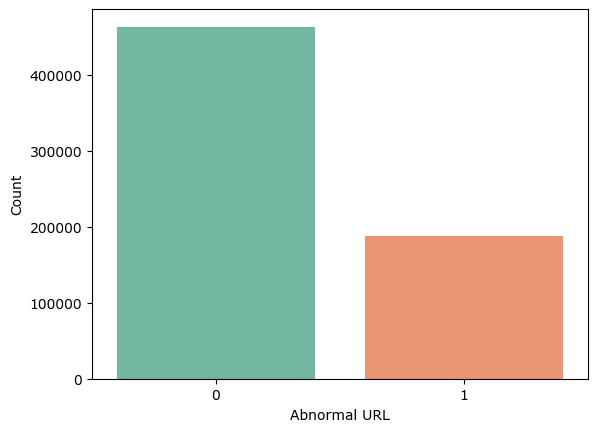

In [16]:
# 'abnormal_url' sütununun değerlerini çubuk grafik ile görselleştirme
sns.countplot(x='abnormal_url', data=data, hue='abnormal_url', dodge=False, palette="Set2", legend=False)
plt.xlabel("Abnormal URL")  # x ekseni etiketi
plt.ylabel("Count")         # y ekseni etiketi
plt.show()

In [17]:
# URL'nin HTTPS kullanıp kullanmadığını kontrol eden fonksiyon
def httpSecure(url):
    htp = urlparse(url).scheme       # URL'nin protokol kısmını al
    match = str(htp)                 # Protokolü stringe çevir
    if match == 'https':             # Eğer protokol https ise
        return 1                     # HTTPS kullanılıyor olarak işaretle
    else:
        return 0                     # HTTPS kullanılmıyor olarak işaretle

In [18]:
# URL'nin güvenli (HTTPS) olup olmadığını belirlemek için 'https' sütunu oluşturma
data['https'] = data['url'].apply(lambda i: httpSecure(i))

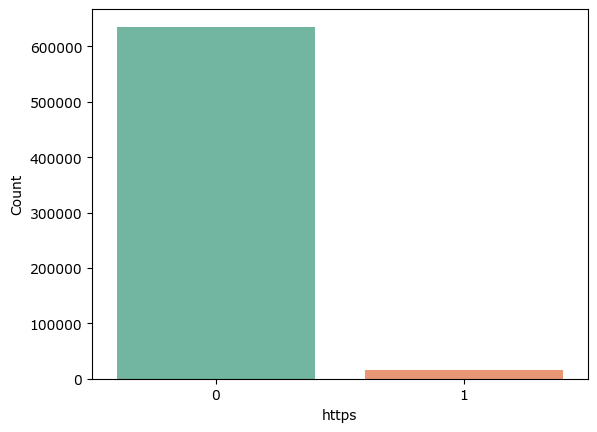

In [19]:
# 'https' sütununun değerlerini çubuk grafik ile görselleştirme
sns.countplot(x='https', data=data, hue='https', dodge=False, palette="Set2", legend=False)
plt.xlabel("https")  # x ekseni etiketi
plt.ylabel("Count")         # y ekseni etiketi
plt.show()

In [20]:
# URL içerisindeki rakamların sayısını hesaplayan fonksiyon
# Her karakter kontrol edilir; eğer rakam ise sayaca eklenir ve toplam rakam sayısı döndürülür
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [21]:
# Her URL için rakam sayısını belirleyip yeni bir sütuna ekleme
data['digits'] = data['url'].apply(lambda i: digit_count(i))

In [22]:
# Her URL'deki harflerin sayısını hesaplayıp yeni bir sütuna ekleme
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [23]:
# Her URL'deki harf sayısını hesaplayarak "letters" sütununa ekleme
data["letters"] = data["url"].apply(lambda i: letter_count(i))

In [24]:
# Model eğitimi için özellikler ve hedef değişkeni ayırma
# "X" değişkeni, sayısal özellikleri içeren veri seti olacak
# "y" değişkeni, her URL'nin kategorisini temsil eden kodları içerecek
X = data.drop(['url','type','Category','domain'], axis=1)
y = data['Category']

In [25]:
# Veriyi eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [26]:
# Performans değerlendirmesi için gerekli metriklerin import edilmesi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [27]:
# Farklı sınıflandırma modellerinin eğitilmesi ve test seti üzerinde performanslarının değerlendirilmesi
# Modelleri 3 gruba ayırıyoruz
models_group1 = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]
models_group2 = [KNeighborsClassifier]
models_group3 = [SGDClassifier]
models_group4 = [ExtraTreesClassifier, GaussianNB]

# Model değerlendirme fonksiyonu
# Model değerlendirme fonksiyonu (KNN için hızlandırma eklenmiş)
def evaluate_models(model_list, X_train, y_train, X_test, y_test):
    accuracy_test = []  # Her modelin doğruluk değerlerini saklamak için boş bir liste
    for m in model_list:
        print("############################################")
        print('######-Model =>\033[07m {} \033[0m'.format(m))  # Modelin adı gösteriliyor
        
        # 🔹 Eğer KNN ise hızlandırıcı parametrelerle çağır
        if m.__name__ == "KNeighborsClassifier":
            model_ = m(
                n_neighbors=5,
                algorithm="kd_tree",  # 'ball_tree' da denenebilir
                leaf_size=30,
                n_jobs=-1
            )
        else:
            model_ = m()  # Diğer modeller varsayılan
        
        # Eğitim ve tahmin
        model_.fit(X_train, y_train)  
        pred = model_.predict(X_test)  
        
        # Doğruluk hesaplama
        acc = accuracy_score(y_test, pred)  
        accuracy_test.append(acc)  
        
        # Sonuçların yazdırılması
        print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))  
        print('\033[01m Classification_report \033[0m')  
        print(classification_report(y_test, pred))  
        print('\033[01m Confusion_matrix \033[0m')  
        
        # Confusion matrix görselleştirme
        cf_matrix = confusion_matrix(y_test, pred)  
        sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='0.2%', cmap="Set2")  
        plt.show()
        
        print("\033[31m###########-End-################\033[0m")  
    
    return accuracy_test

############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  92.40%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     85565
           1       0.93      0.96      0.95     19319
           2       0.79      0.70      0.75     18805
           3       0.94      0.91      0.93      6550

    accuracy                           0.92    130239
   macro avg       0.90      0.89      0.89    130239
weighted avg       0.92      0.92      0.92    130239

 Confusion_matrix 


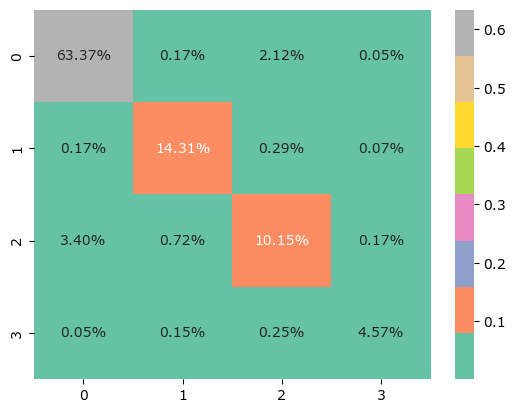

###########-End-################
############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  92.95%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     85565
           1       0.94      0.97      0.95     19319
           2       0.81      0.71      0.76     18805
           3       0.96      0.91      0.93      6550

    accuracy                           0.93    130239
   macro avg       0.91      0.89      0.90    130239
weighted avg       0.93      0.93      0.93    130239

 Confusion_matrix 


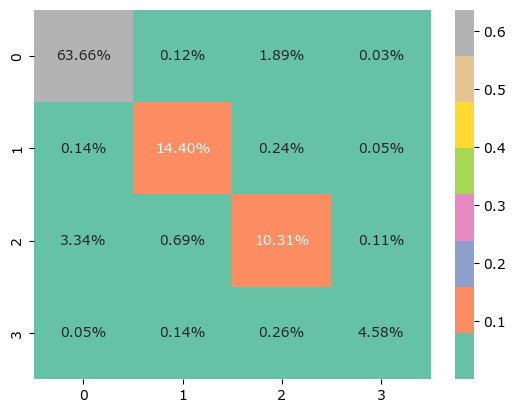

###########-End-################
############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  76.66%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     85565
           1       0.68      0.63      0.65     19319
           2       0.38      0.25      0.30     18805
           3       0.40      0.62      0.49      6550

    accuracy                           0.77    130239
   macro avg       0.58      0.61      0.59    130239
weighted avg       0.75      0.77      0.76    130239

 Confusion_matrix 


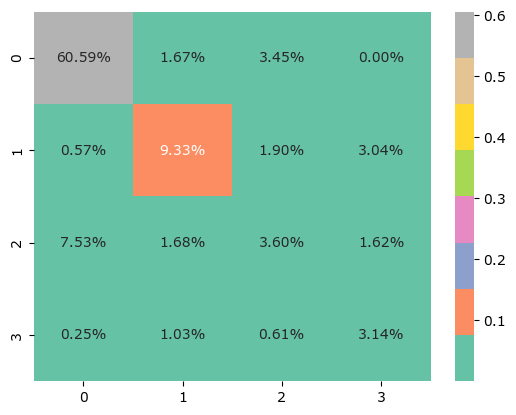

###########-End-################


In [27]:
# Her grup için modeli çalıştır
accuracy_group1 = evaluate_models(models_group1, X_train, y_train, X_test, y_test)

############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  90.76%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     85565
           1       0.90      0.95      0.92     19319
           2       0.78      0.63      0.70     18805
           3       0.94      0.87      0.91      6550

    accuracy                           0.91    130239
   macro avg       0.89      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

 Confusion_matrix 


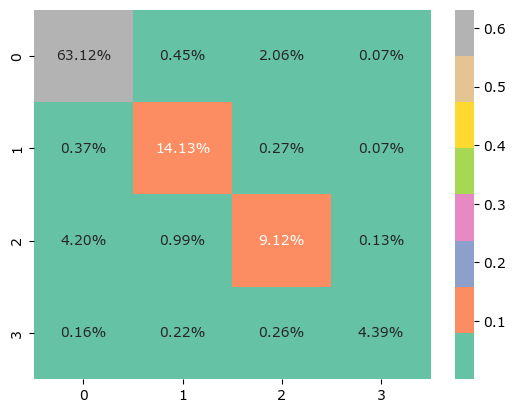

###########-End-################


In [28]:
accuracy_group2 = evaluate_models(models_group2, X_train, y_train, X_test, y_test)

############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  81.07%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     85565
           1       0.75      0.95      0.84     19319
           2       0.39      0.06      0.10     18805
           3       0.90      0.36      0.51      6550

    accuracy                           0.81    130239
   macro avg       0.72      0.59      0.59    130239
weighted avg       0.76      0.81      0.76    130239

 Confusion_matrix 


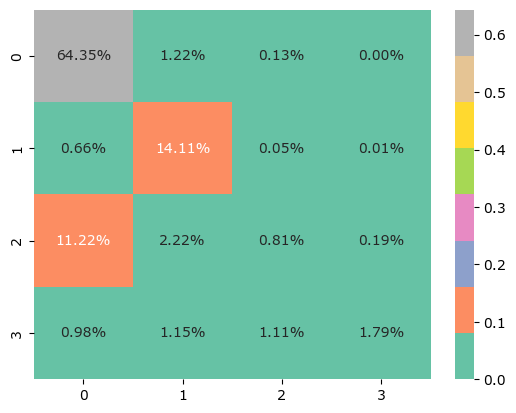

###########-End-################


In [29]:
accuracy_group3 = evaluate_models(models_group3, X_train, y_train, X_test, y_test)

############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  92.97%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     85565
           1       0.94      0.97      0.95     19319
           2       0.82      0.71      0.76     18805
           3       0.96      0.91      0.93      6550

    accuracy                           0.93    130239
   macro avg       0.92      0.89      0.90    130239
weighted avg       0.93      0.93      0.93    130239

 Confusion_matrix 


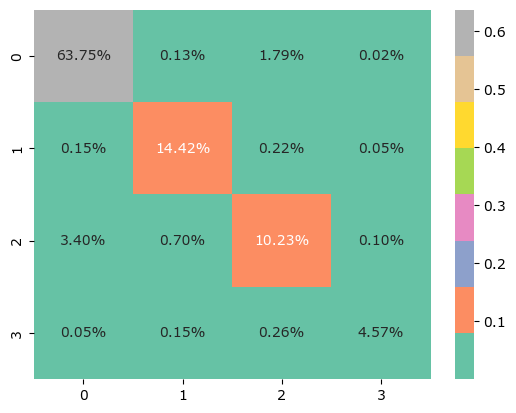

###########-End-################
############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  77.00%  
 Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85565
           1       0.60      1.00      0.75     19319
           2       0.57      0.02      0.03     18805
           3       0.43      0.34      0.38      6550

    accuracy                           0.77    130239
   macro avg       0.61      0.57      0.51    130239
weighted avg       0.75      0.77      0.71    130239

 Confusion_matrix 


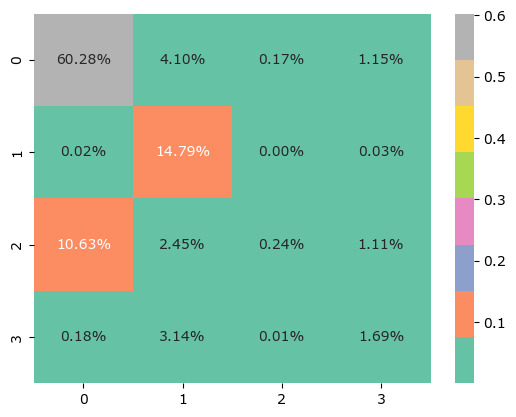

###########-End-################


In [30]:
accuracy_group4 = evaluate_models(models_group4, X_train, y_train, X_test, y_test)

Model karşılaştırmaları sonucunda en yüksek doğruluk oranını Random Forest ve ExtraTrees modelleri vermiştir (yaklaşık %93). Bu yöntemler, birden fazla karar ağacını bir araya getirerek daha dengeli ve kararlı tahminler yapabilmektedir. Decision Tree modeli tek başına da yüksek bir başarı göstermiştir (%92), ancak daha fazla hata yapma riski taşımaktadır. KNN modeli %91 doğruluk elde etmesine rağmen, büyük veri setlerinde oldukça yavaş çalıştığı için pratik bir tercih değildir. Buna karşın, AdaBoost, Naive Bayes ve SGDClassifier modelleri düşük performans sergilemiş ve özellikle bazı zararlı URL türlerini ayırt etmede zorlanmıştır. Genel olarak, bu veri seti için en uygun yöntemlerin Random Forest ve ExtraTrees olduğu, çünkü hem yüksek doğruluk oranı sağladıkları hem de farklı zararlı site türlerinde diğer modellere kıyasla daha dengeli sonuçlar ürettikleri görülmüştür.